In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from xgboost import XGBClassifier
import statsmodels.api as sms

In [2]:
df1= pd.read_csv('train.csv')
df2=pd.read_csv('test.csv')
df1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data Analysis 

In [3]:
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [4]:
df1.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

checking the missing values visually

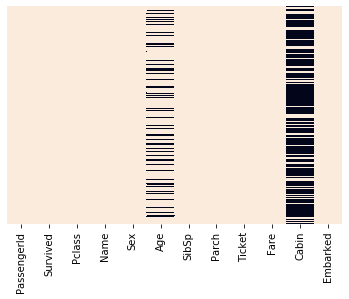

In [5]:
sns.heatmap(df1.notnull(),cbar=False,yticklabels=False)

In [6]:
Train_Age_avail=df1['Age'].count()/len(df1['Age'])
Train_Cabin_avail=df1['Cabin'].count()/len(df1['Cabin'])
print('Percentage of available values of Age and Cabin in Train ', Train_Age_avail, Train_Cabin_avail)
Test_Age_avail=df2['Age'].count()/len(df2['Age'])
Test_Cabin_avail=df2['Cabin'].count()/len(df2['Cabin'])
print('Percentage of available values of Age and Cabin in Train ', Test_Age_avail, Test_Cabin_avail)

Percentage of available values of Age and Cabin in Train  0.8013468013468014 0.22895622895622897
Percentage of available values of Age and Cabin in Train  0.7942583732057417 0.21770334928229665


Observation 1:
    1. Age has ~80% values and cabin ~21-22% values in both Train and test
    2. Checking the Age distribution, we can fill the missing values through central tendency approach
    3. Filling ~80% of values for missing Cabin would not be valid. So we can think of dropping the column cabin if that is not significant

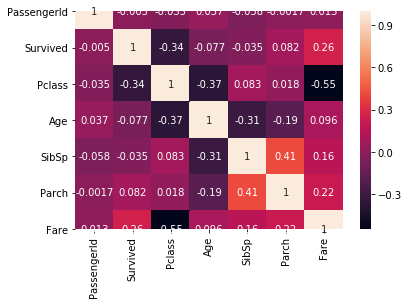

In [7]:
sns.heatmap(df1.corr(), annot=True)

Observation 2:
    1. No major correlation between most of the features except few
    2. As expected Pclass and Fare are inversely proportional (higher the fare, higher the class (denoted as less numeric value)
    3. Parch and Sibsp has some correlation, but not the point high significance to remove any features

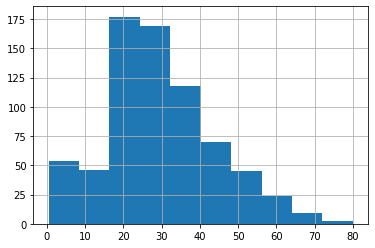

In [8]:
df1['Age'].hist(bins=10)

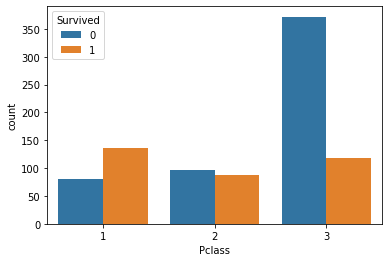

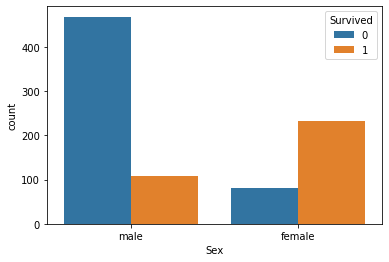

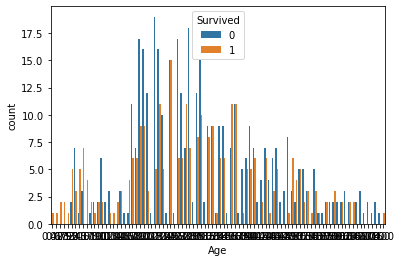

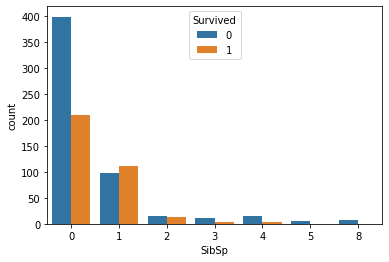

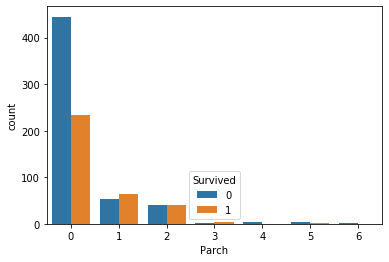

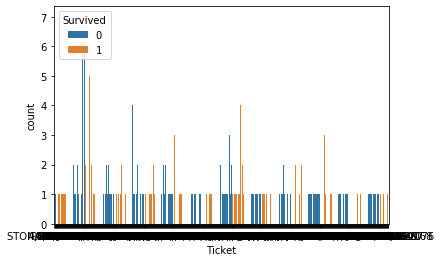

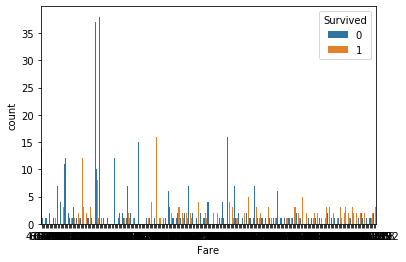

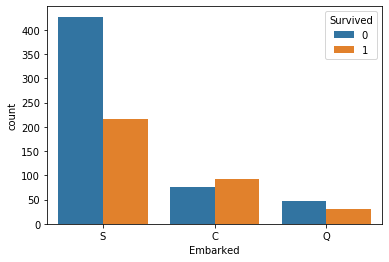

In [9]:
col_list=list(df1.columns)
col_list.remove('Survived')
col_list.remove('PassengerId')
col_list.remove('Name')
col_list.remove('Cabin')
for i in col_list:
    plt.figure()
    sns.countplot(x=df1[i], hue=df1['Survived'])


Observation 3:
On performimg Bivariate analysis against our target (Survived feature) against other features (ignore the obvious - PassengerId, Name, Cabin, Ticket, Fare etc)
1. More Females survived than Males
2. Higher the class levels (1 and 2) more Survived
3. People with 1,2,3 SibSp or Parch had more Survived, compared to People with 0 or greater than 3 Sibsp/Pacrh
4. People with high Fare had Survived - obvious it should have been from High Pclass
5. Visual check shows people in the median age group (20-30's) had less survived compared to other Age groups - we can box the Ages

In [10]:
#Fill missing values in Age with median of the group
df1['Age'].fillna(df1['Age'].median(),inplace=True)
df2['Age'].fillna(df2['Age'].median(),inplace=True)
df1[df1['Age'].notnull()].count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            891
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [11]:
#Box the ages in groups
cat_age=pd.cut(df1['Age'],bins=[0,20,30,40,60,80], labels=[1,2,3,4,5])
df1.insert(6,'AgeBox',cat_age)
cat_age=pd.cut(df2['Age'],bins=[0,20,30,40,60,80], labels=[1,2,3,4,5])
df2.insert(6,'AgeBox',cat_age)

In [12]:
df1.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex              object
Age             float64
AgeBox         category
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked         object
dtype: object

Based on Observation3, we are performing multivariate analysis on the data with reference to multiple features

In [13]:
df1.groupby(['Pclass','Sex','Survived'])['Name'].count()

Pclass  Sex     Survived
1       female  0             3
                1            91
        male    0            77
                1            45
2       female  0             6
                1            70
        male    0            91
                1            17
3       female  0            72
                1            72
        male    0           300
                1            47
Name: Name, dtype: int64

Observation 4:
1. Pclass 1 - Survival rate-62.96%, Female(94) Survival rate-96.80%, Male(122) Survival rate-36.88%
2. Pclass 2 - Survival rate-47.28%, Female(76) Survival rate-92.10%, Male(108) Survival rate-15.74%
3. Pclass 3 - Survival rate-24.23%, Female(144) Survival rate-50.0%, Male(347) Survival rate-13.54%

Observation 5:
1. Add the SibSp and Parch into a single field, considering its correlation 
2. Drop the 2 separate fields

In [14]:
df1['Dependents'] = df1['SibSp']+df1['Parch']
df2['Dependents'] = df2['SibSp']+df2['Parch']
df1.drop(['SibSp','Parch'], axis=1,inplace=True)

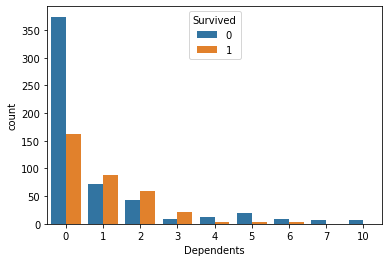

In [15]:
sns.countplot(df1['Dependents'],hue=df1['Survived'])

Observation 6:
1. People who had dependents had high Survival rate, compared to people without dependents
2. Of that people who had less dependents <3, had better survival rate

# Feature Engineering

In [16]:
#Convert Embarked by Label encoding
from sklearn.preprocessing import LabelEncoder
lbe = LabelEncoder()
df1['Embarked_Code']=lbe.fit_transform(df1['Embarked'].astype(str))
df2['Embarked_Code']=lbe.fit_transform(df2['Embarked'].astype(str))

In [17]:
#Convert Sex into categories
gender={"male":1,"female":2}
df1['Sex']=[gender[x] for x in df1['Sex']]
df2['Sex']=[gender[x] for x in df2['Sex']]

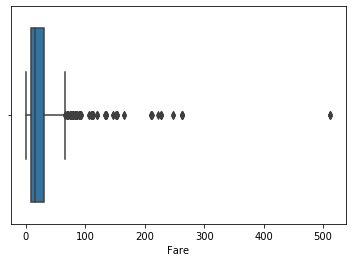

In [18]:
sns.boxplot(df1['Fare'])

In [19]:
print(df1[df1['Fare']>125]['Pclass'].value_counts())
print(df2[df2['Fare']>125]['Pclass'].value_counts())

1    38
Name: Pclass, dtype: int64
1    29
Name: Pclass, dtype: int64


Observation 7:
1. There are quite outliers in Fare and as expected the higher outlier is in PClass1
2. Let us replace the outliers with median of Pclass1 to avoid any impurity of data

In [20]:
print(df1[df1['Pclass']==1]['Fare'].median())
print(df2[df2['Pclass']==1]['Fare'].median())

60.287499999999994
60.0


In [21]:
df1.loc[df1['Fare']>100,'Fare']=df1[df1['Pclass']==1]['Fare'].median()
df2.loc[df2['Fare']>100,'Fare']=df2[df2['Pclass']==1]['Fare'].median()

In [22]:
print(df1[df1['Fare']>100]['Pclass'].value_counts())
print(df2[df2['Fare']>100]['Pclass'].value_counts())

Series([], Name: Pclass, dtype: int64)
Series([], Name: Pclass, dtype: int64)


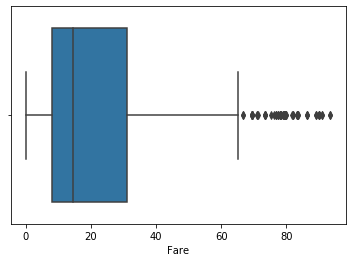

In [23]:
sns.boxplot(df1['Fare'])

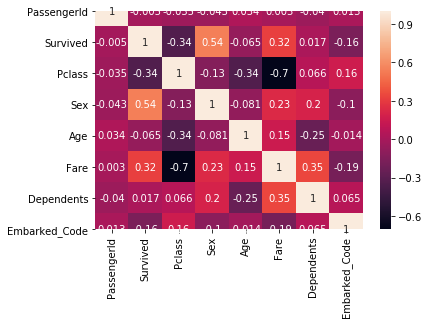

In [24]:
sns.heatmap(df1.corr(),annot=True)

In [25]:
df1['AgeBox']= pd.to_numeric(df1['AgeBox'])
df2['AgeBox']= pd.to_numeric(df2['AgeBox'])

Observation 8:
1. There is no need to split the names and group the Lastname and compare, as we have already created Dependents feature. So can drop Name
2. Age could also be dropped as we have AgeBox created, and so is Embarked as Embarked_Code is created
3. Cabin with only 20% of data, could be dropped
4. Ticket could also be dropped, as not significant with Alphanumeric or just Alphabets
5. PassengerId - retaining for now, as not sure on the significance in enuermating thr results. But for model building its of no significance
6.Fare and Pclass are also negatively correlated. So we can drop Fare too

In [26]:
df1.drop(['Name','Age','Ticket','Cabin','Embarked','Fare'], axis=1,inplace=True)
df2.drop(['Name','Age','Ticket','Cabin','Embarked','Fare'], axis=1,inplace=True)

In [27]:
#Re-arranging the columns
df1=df1[['PassengerId','Pclass','Sex','AgeBox','Dependents','Embarked_Code','Survived']]
df2=df2[['PassengerId','Pclass','Sex','AgeBox','Dependents','Embarked_Code']]
df1.head()

,PassengerId,Pclass,Sex,AgeBox,Dependents,Embarked_Code,Survived
0,1,3,1,2,1,2,0
1,2,1,2,3,1,0,1
2,3,3,2,2,0,2,1
3,4,1,2,3,1,2,1
4,5,3,1,3,0,2,0


In [28]:
y=df1.iloc[:,-1]
X=df1.iloc[:,:-1]

In [29]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

# Logistic Regression

In [30]:
#Logical Regression and check P values
logReg=LogisticRegression()
logReg.fit(X_train,y_train)
y1_pred=logReg.predict(X_test)
print("Accuracy Score for Logical Regression is ",accuracy_score(y1_pred,y_test))
print("Confusion Matrix for Logical Regression is ",confusion_matrix(y1_pred,y_test))

Accuracy Score for Logical Regression is  0.8097014925373134
Confusion Matrix for Logical Regression is  [[137  31]
 [ 20  80]]


# Logit

In [31]:
logres=sms.Logit(y_train,X_train)
res=logres.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.462671
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  623
Model:                          Logit   Df Residuals:                      617
Method:                           MLE   Df Model:                            5
Date:                Fri, 03 Jul 2020   Pseudo R-squ.:                  0.2983
Time:                        01:25:10   Log-Likelihood:                -288.24
converged:                       True   LL-Null:                       -410.79
Covariance Type:            nonrobust   LLR p-value:                 6.215e-51
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
PassengerId    8.017e-05      0.000      0.214      0.831      -0.001       0.001
Pclass           -1.

Observation 9:
As expected PassengerId has high P value. We can remove them in later instance. Remaining features are valid

# Random Forest Classifier

In [32]:
rfcls= RandomForestClassifier(n_estimators=50,criterion='gini',min_samples_leaf=3,max_depth=20,random_state=42)
rfcls.fit(X_train, y_train)
y2_pred=rfcls.predict(X_test)
print("Accuracy Score for Random Forest Classifier is ",accuracy_score(y2_pred,y_test))
print("Confusion Matrix for Random Forest Classifier is ",confusion_matrix(y2_pred,y_test))

Accuracy Score for Random Forest Classifier is  0.8134328358208955
Confusion Matrix for Random Forest Classifier is  [[143  36]
 [ 14  75]]


In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
svm=SVC()
c=[1.0, 0.25, 0.5, 0.75]
kernels = ['linear', 'rbf']
gammas = ['auto', 0.01, 0.001, 1]

grcs=GridSearchCV(estimator=svm, param_grid=dict(kernel=kernels, C=c, gamma=gammas))
grcs.fit(X_train, y_train)
y3_pred=rfcls.predict(X_test)
print("Accuracy Score for Grid Search Classifier is ",accuracy_score(y3_pred,y_test))
print("Confusion Matrix for Random Forest Classifier is ",confusion_matrix(y3_pred,y_test))

Accuracy Score for Grid Search Classifier is  0.8134328358208955
Confusion Matrix for Random Forest Classifier is  [[143  36]
 [ 14  75]]


# Decision Tree Classifier

In [34]:
dtree= DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)
y3_pred=rfcls.predict(X_test)
print("Accuracy Score for Decision Tree Classifier is ",accuracy_score(y3_pred,y_test))
print("Confusion Matrix for Decision Tree Classifier is ",confusion_matrix(y3_pred,y_test))

Accuracy Score for Decision Tree Classifier is  0.8134328358208955
Confusion Matrix for Decision Tree Classifier is  [[143  36]
 [ 14  75]]


# XGBoost

In [35]:
xgbins = XGBClassifier(random_state=42)
xgb_mod=xgbins.fit(X_train,y_train)
y4_pred=xgbins.predict(X_test)
print("Accuracy Score for XGBoost is ",accuracy_score(y4_pred,y_test))
print("Confusion Matrix for XGBoost is ",confusion_matrix(y4_pred,y_test))

Accuracy Score for XGBoost is  0.7985074626865671
Confusion Matrix for XGBoost is  [[137  34]
 [ 20  77]]


# AdaBoost Classifier

In [36]:
adbs=AdaBoostClassifier()
adbs_mod=adbs.fit(X_train,y_train)
y5_pred=xgbins.predict(X_test)
print("Accuracy Score for AdaBoost is ",accuracy_score(y5_pred,y_test))
print("Confusion Matrix for AdaBoost is ",confusion_matrix(y5_pred,y_test))

Accuracy Score for AdaBoost is  0.7985074626865671
Confusion Matrix for AdaBoost is  [[137  34]
 [ 20  77]]


# GradientBoost Classifier

In [44]:
grdbst=GradientBoostingClassifier(n_estimators=50,min_samples_leaf=3,max_depth=20,random_state=42)
grb_mod=grdbst.fit(X_train,y_train)
y6_pred=grb_mod.predict(X_test)
print("Accuracy Score for Gradient Boost Classifier is ",accuracy_score(y6_pred,y_test))
print("Confusion Matrix for Gradient Boost Classifier is ",confusion_matrix(y6_pred,y_test))

Accuracy Score for Gradient Boost Classifier is  0.7910447761194029
Confusion Matrix for Gradient Boost Classifier is  [[136  35]
 [ 21  76]]


Now that RandomForest has provided a good output, let us use this on original test data

In [40]:
y_test_pred=rfcls.predict(df2)
print(y_test_pred)

[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0
 0 1 0 1 1 0 0 1 0 0 0]


In [43]:
result=pd.DataFrame({'PassengerId':df2['PassengerId'],'Survived':y_test_pred})
result.to_csv

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
